# Population Density Prediction: Multi-Resolution Analysis

This notebook tests SatCLIP's ability to predict population density at different spatial resolutions,
**matching the methodology from Table 2 of the SatCLIP paper**.

## Dataset
**GPWv4** (Gridded Population of the World, Version 4)
- 5 native resolutions: 30-sec (~1km), 2.5-min (~5km), 15-min (~28km), 30-min (~55km), 1-deg (~111km)
- Years: 2000, 2005, 2010, 2015, 2020
- Values: Population density (persons per km²)

## Paper Methodology (Table 2)
- **Scope**: Global (standard evaluation)
- **Split**: 50% train / 50% test (random)
- **Model**: MLP on frozen SatCLIP embeddings
- **Target**: Log-transformed population density
- **Metric**: R² score
- **Paper Results**: L=10 R²=0.79, L=40 R²=0.82

## Available Models
- **L=10**: 100 spherical harmonic features → 256-dim embedding
- **L=40**: 1600 spherical harmonic features → 256-dim embedding
- **Note**: No L=20 model exists on HuggingFace (only L=10 and L=40)

## Tests in This Notebook
1. **Paper Replication**: Global test matching Table 2 methodology
2. **Multi-Resolution**: Compare L=10 vs L=40 at each GPW resolution
3. **Regional Analysis**: Additional tests within constrained regions (exploratory)

**Key Question**: Does L=40 advantage change with population data resolution?

In [1]:
# Setup
import os
import sys

# Handle both Colab and local environments
if 'COLAB_GPU' in os.environ:
    !rm -rf sample_data .config satclip gpw_data 2>/dev/null
    !git clone https://github.com/1hamzaiqbal/satclip.git

    # Download GPW data (we'll use a subset)
    !pip install gdown --quiet
    # Note: You'll need to upload the gpw_data folder or download from source
    print("Please upload gpw_data folder with population TIF files")

!pip install lightning torchgeo huggingface_hub geopandas shapely requests --quiet

Cloning into 'satclip'...
remote: Enumerating objects: 397, done.
remote: Counting objects: 100% (210/210), done.
remote: Compressing objects: 100% (98/98), done.
remote: Total 397 (delta 159), reused 133 (delta 112), pack-reused 187 (from 2)
Receiving objects: 100% (397/397), 79.67 MiB | 23.76 MiB/s, done.
Resolving deltas: 100% (187/187), done.
Updating files: 100% (89/89), done.
Please upload gpw_data folder with population TIF files
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.9/44.9 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 846.0/846.0 kB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 46.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.9/243.9 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 49.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 859.3/859.3 kB 48.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.5/849.5 kB 40.9 MB/s eta 0:00:

In [7]:
# === COLAB SETUP: GPW Population Data ===
from google.colab import drive
drive.mount('/content/drive')

import os
import zipfile

GPW_DIR = './gpw_data'
os.makedirs(GPW_DIR, exist_ok=True)

# Source path in Google Drive
SOURCE_ZIP_PATH = '/content/drive/MyDrive/grad/learned_activations/dataverse_files.zip'

print("Step 1: Extracting main archive...")
with zipfile.ZipFile(SOURCE_ZIP_PATH, 'r') as z:
    z.extractall(GPW_DIR)

print("Step 2: Extracting nested TIF zips...")
# Only extract the resolutions we need (skip 30_sec which is huge)
RESOLUTIONS_TO_EXTRACT = ['1_deg', '30_min', '15_min', '2pt5_min']
YEAR = 2020

extracted = 0
for res in RESOLUTIONS_TO_EXTRACT:
    zip_name = f"gpw-v4-population-density-rev11_{YEAR}_{res}_tif.zip"
    zip_path = os.path.join(GPW_DIR, zip_name)

    if os.path.exists(zip_path):
        with zipfile.ZipFile(zip_path, 'r') as z:
            z.extractall(GPW_DIR)
        extracted += 1
        print(f"  ✓ Extracted {zip_name}")

print(f"\nStep 3: Verifying TIF files...")
tif_files = [f for f in os.listdir(GPW_DIR) if f.endswith('.tif')]
print(f"  Found {len(tif_files)} TIF files:")
for f in sorted(tif_files):
    size_mb = os.path.getsize(os.path.join(GPW_DIR, f)) / 1e6
    print(f"    {f} ({size_mb:.1f} MB)")

print("\n✅ Setup complete!")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Step 1: Extracting main archive...
Step 2: Extracting nested TIF zips...
  ✓ Extracted gpw-v4-population-density-rev11_2020_1_deg_tif.zip
  ✓ Extracted gpw-v4-population-density-rev11_2020_30_min_tif.zip
  ✓ Extracted gpw-v4-population-density-rev11_2020_15_min_tif.zip
  ✓ Extracted gpw-v4-population-density-rev11_2020_2pt5_min_tif.zip

Step 3: Verifying TIF files...
  Found 4 TIF files:
    gpw_v4_population_density_rev11_2020_15_min.tif (1.1 MB)
    gpw_v4_population_density_rev11_2020_1_deg.tif (0.1 MB)
    gpw_v4_population_density_rev11_2020_2pt5_min.tif (24.8 MB)
    gpw_v4_population_density_rev11_2020_30_min.tif (0.3 MB)

✅ Setup complete!


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import zipfile
import io
import warnings
warnings.filterwarnings('ignore')

# Path setup
if 'COLAB_GPU' in os.environ:
    sys.path.append('./satclip/satclip')
    GPW_DIR = './gpw_data'
else:
    sys.path.append(os.path.join(os.path.dirname(os.getcwd()), 'satclip'))
    GPW_DIR = './gpw_data'

import torch
from huggingface_hub import hf_hub_download
from load import get_satclip
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load models
print("Loading SatCLIP models...")
model_l10 = get_satclip(hf_hub_download("microsoft/SatCLIP-ViT16-L10", "satclip-vit16-l10.ckpt"), device=device)
model_l40 = get_satclip(hf_hub_download("microsoft/SatCLIP-ViT16-L40", "satclip-vit16-l40.ckpt"), device=device)
model_l10.eval()
model_l40.eval()
print("Models loaded!")

def get_embeddings(model, coords, batch_size=1000):
    """Get embeddings with batching for large coordinate sets."""
    all_emb = []
    for i in range(0, len(coords), batch_size):
        batch = coords[i:i+batch_size]
        coords_tensor = torch.tensor(batch).double()
        with torch.no_grad():
            emb = model(coords_tensor.to(device)).cpu().numpy()
        all_emb.append(emb)
    return np.vstack(all_emb)

Using device: cuda
Loading SatCLIP models...


satclip-vit16-l10.ckpt:   0%|          | 0.00/103M [00:00<?, ?B/s]

using pretrained moco vit16
Downloading: "https://hf.co/torchgeo/vit_small_patch16_224_sentinel2_all_moco/resolve/1cb683f6c14739634cdfaaceb076529adf898c74/vit_small_patch16_224_sentinel2_all_moco-67c9032d.pth" to /root/.cache/torch/hub/checkpoints/vit_small_patch16_224_sentinel2_all_moco-67c9032d.pth


100%|██████████| 86.5M/86.5M [00:00<00:00, 249MB/s]


satclip-vit16-l40.ckpt:   0%|          | 0.00/121M [00:00<?, ?B/s]

using pretrained moco vit16
Models loaded!


---
## 1. Load and Explore GPW Data

In [9]:
# Define available resolutions
RESOLUTIONS = {
    '1_deg': {'name': '1 degree', 'km': 111, 'grid': (360, 180)},
    '30_min': {'name': '30 arc-min', 'km': 55, 'grid': (720, 360)},
    '15_min': {'name': '15 arc-min', 'km': 28, 'grid': (1440, 720)},
    '2pt5_min': {'name': '2.5 arc-min', 'km': 5, 'grid': (8640, 4320)},
}

YEAR = 2020

def load_gpw_raster(resolution, year=2020):
    """Load GPW population density raster at given resolution."""
    # Map resolution key to TIF filename pattern
    res_to_filename = {
        '1_deg': '1_deg',
        '30_min': '30_min',
        '15_min': '15_min',
        '2pt5_min': '2pt5_min',
    }

    tif_file = f"{GPW_DIR}/gpw_v4_population_density_rev11_{year}_{res_to_filename[resolution]}.tif"

    if not os.path.exists(tif_file):
        print(f"File not found: {tif_file}")
        return None, None

    # Read TIF directly
    img = Image.open(tif_file)
    data = np.array(img)

    # Create coordinate grids
    height, width = data.shape
    lon_step = 360 / width
    lat_step = 180 / height

    lons = np.linspace(-180 + lon_step/2, 180 - lon_step/2, width)
    lats = np.linspace(90 - lat_step/2, -90 + lat_step/2, height)

    return data, (lons, lats)

# Test loading
print("Testing data loading...")
for res_key, res_info in RESOLUTIONS.items():
    data, coords = load_gpw_raster(res_key)
    if data is not None:
        valid = data > -1e30
        print(f"{res_info['name']:15} ({res_info['km']:>3}km): {data.shape} - {valid.sum():,} valid cells")


Testing data loading...
1 degree        (111km): (180, 360) - 19,103 valid cells
30 arc-min      ( 55km): (360, 720) - 70,123 valid cells
15 arc-min      ( 28km): (720, 1440) - 266,090 valid cells
2.5 arc-min     (  5km): (4320, 8640) - 9,040,743 valid cells


In [10]:
def sample_from_raster(data, coords, n_samples=10000, seed=42, bounds=None):
    """
    Sample random valid points from population raster.

    Args:
        data: 2D array of population density
        coords: (lons, lats) arrays
        n_samples: number of samples
        seed: random seed
        bounds: optional (lon_min, lat_min, lon_max, lat_max) to constrain region

    Returns:
        coords_arr: (N, 2) array of [lon, lat]
        values: (N,) array of population density values
    """
    np.random.seed(seed)
    lons, lats = coords

    # Create valid mask
    valid_mask = data > -1e30

    # Apply bounds if specified
    if bounds is not None:
        lon_min, lat_min, lon_max, lat_max = bounds
        lon_grid, lat_grid = np.meshgrid(lons, lats)
        bounds_mask = (
            (lon_grid >= lon_min) & (lon_grid <= lon_max) &
            (lat_grid >= lat_min) & (lat_grid <= lat_max)
        )
        valid_mask = valid_mask & bounds_mask

    # Get valid indices
    valid_idx = np.where(valid_mask)
    n_valid = len(valid_idx[0])

    if n_valid < n_samples:
        print(f"Warning: Only {n_valid} valid cells, sampling all")
        sample_idx = np.arange(n_valid)
    else:
        sample_idx = np.random.choice(n_valid, n_samples, replace=False)

    # Get coordinates and values
    row_idx = valid_idx[0][sample_idx]
    col_idx = valid_idx[1][sample_idx]

    sample_lons = lons[col_idx]
    sample_lats = lats[row_idx]
    sample_values = data[row_idx, col_idx]

    coords_arr = np.stack([sample_lons, sample_lats], axis=1)

    return coords_arr, sample_values

# Test sampling
data_15min, coords_15min = load_gpw_raster('15_min')
sample_coords, sample_vals = sample_from_raster(data_15min, coords_15min, n_samples=1000)
print(f"Sampled {len(sample_coords)} points")
print(f"Coords range: lon [{sample_coords[:,0].min():.1f}, {sample_coords[:,0].max():.1f}], lat [{sample_coords[:,1].min():.1f}, {sample_coords[:,1].max():.1f}]")
print(f"Pop density range: [{sample_vals.min():.1f}, {sample_vals.max():.1f}] persons/km²")

Sampled 1000 points
Coords range: lon [-179.6, 179.9], lat [-52.1, 83.4]
Pop density range: [0.0, 4840.9] persons/km²


---
## 2. Multi-Resolution Population Prediction (Global)

In [11]:
def run_population_regression(coords, values, model_l10, model_l40, test_size=0.5, seed=42):
    """
    Train and evaluate population regression for both L=10 and L=40.

    Matches SatCLIP paper methodology:
    - 50/50 train/test split (paper uses 50%)
    - Log-transformed population density
    - MLP regressor on frozen embeddings

    Returns dict with R², MSE for each model.
    """
    # Log-transform population (paper uses "logged Population Density")
    # Add small constant to handle zeros
    y = np.log1p(values)

    # Get embeddings
    emb_l10 = get_embeddings(model_l10, coords)
    emb_l40 = get_embeddings(model_l40, coords)

    # Train/test split - Paper uses 50/50
    X_train_l10, X_test_l10, y_train, y_test = train_test_split(
        emb_l10, y, test_size=test_size, random_state=seed
    )
    X_train_l40, X_test_l40, _, _ = train_test_split(
        emb_l40, y, test_size=test_size, random_state=seed
    )

    # Scale features
    scaler_l10 = StandardScaler()
    scaler_l40 = StandardScaler()
    X_train_l10 = scaler_l10.fit_transform(X_train_l10)
    X_test_l10 = scaler_l10.transform(X_test_l10)
    X_train_l40 = scaler_l40.fit_transform(X_train_l40)
    X_test_l40 = scaler_l40.transform(X_test_l40)

    # Train MLP regressors (paper uses MLP with tuned hyperparameters)
    mlp_l10 = MLPRegressor(hidden_layer_sizes=(128, 64), max_iter=500,
                           random_state=seed, early_stopping=True, validation_fraction=0.1)
    mlp_l40 = MLPRegressor(hidden_layer_sizes=(128, 64), max_iter=500,
                           random_state=seed, early_stopping=True, validation_fraction=0.1)

    mlp_l10.fit(X_train_l10, y_train)
    mlp_l40.fit(X_train_l40, y_train)

    # Predict and evaluate
    pred_l10 = mlp_l10.predict(X_test_l10)
    pred_l40 = mlp_l40.predict(X_test_l40)

    r2_l10 = r2_score(y_test, pred_l10)
    r2_l40 = r2_score(y_test, pred_l40)
    mse_l10 = mean_squared_error(y_test, pred_l10)
    mse_l40 = mean_squared_error(y_test, pred_l40)

    return {
        'r2_l10': r2_l10,
        'r2_l40': r2_l40,
        'mse_l10': mse_l10,
        'mse_l40': mse_l40,
        'n_train': len(y_train),
        'n_test': len(y_test)
    }

In [12]:
print("="*70)
print("GLOBAL POPULATION REGRESSION AT DIFFERENT RESOLUTIONS")
print("="*70)

N_SAMPLES = 15000  # Samples per resolution

global_results = []

print(f"\n{'Resolution':>15} | {'~km':>6} | {'R² L=10':>10} | {'R² L=40':>10} | {'Δ':>8} | {'Winner'}")
print("-" * 75)

for res_key, res_info in RESOLUTIONS.items():
    # Load data
    data, coords = load_gpw_raster(res_key)
    if data is None:
        continue

    # Sample points
    sample_coords, sample_vals = sample_from_raster(data, coords, n_samples=N_SAMPLES)

    # Run regression
    results = run_population_regression(sample_coords, sample_vals, model_l10, model_l40)

    diff = results['r2_l40'] - results['r2_l10']
    winner = "L=40" if diff > 0.01 else ("L=10" if diff < -0.01 else "~Same")

    print(f"{res_info['name']:>15} | {res_info['km']:>5}km | {results['r2_l10']:>10.3f} | {results['r2_l40']:>10.3f} | {diff:>+7.3f} | {winner}")

    global_results.append({
        'resolution': res_info['name'],
        'km': res_info['km'],
        'r2_l10': results['r2_l10'],
        'r2_l40': results['r2_l40'],
        'diff': diff,
        'n_samples': len(sample_coords)
    })

global_df = pd.DataFrame(global_results)

GLOBAL POPULATION REGRESSION AT DIFFERENT RESOLUTIONS

     Resolution |    ~km |    R² L=10 |    R² L=40 |        Δ | Winner
---------------------------------------------------------------------------
       1 degree |   111km |      0.826 |      0.823 |  -0.003 | ~Same
     30 arc-min |    55km |      0.800 |      0.809 |  +0.009 | ~Same
     15 arc-min |    28km |      0.788 |      0.797 |  +0.008 | ~Same
    2.5 arc-min |     5km |      0.758 |      0.770 |  +0.011 | L=40


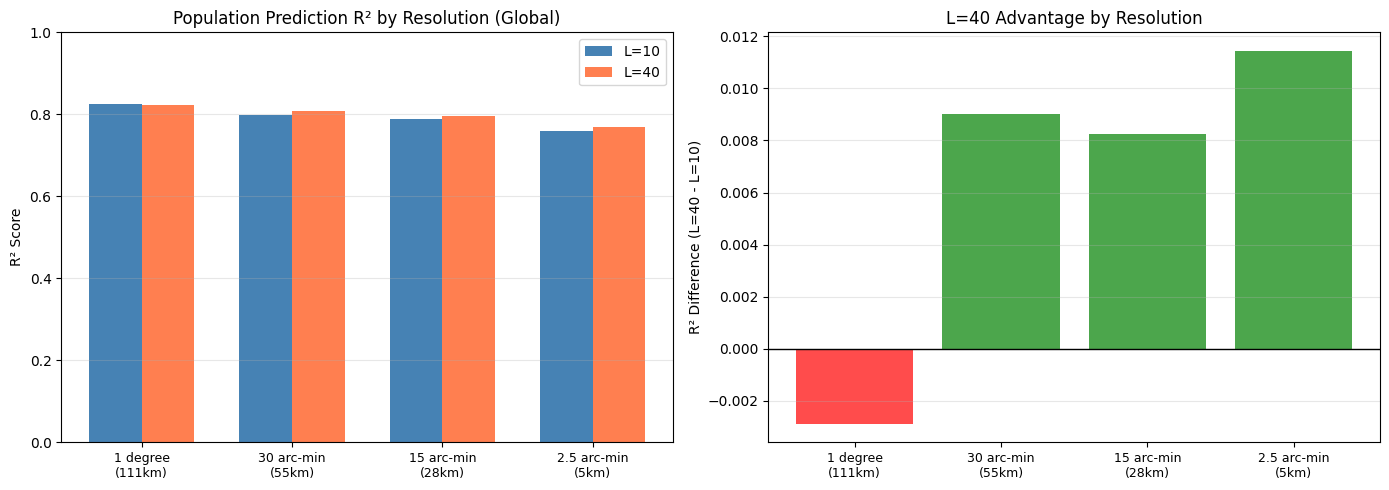

In [13]:
# Visualize global results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# R² by resolution
ax = axes[0]
x = range(len(global_df))
width = 0.35
ax.bar([i - width/2 for i in x], global_df['r2_l10'], width, label='L=10', color='steelblue')
ax.bar([i + width/2 for i in x], global_df['r2_l40'], width, label='L=40', color='coral')
ax.set_xticks(x)
ax.set_xticklabels([f"{r}\n({k}km)" for r, k in zip(global_df['resolution'], global_df['km'])], fontsize=9)
ax.set_ylabel('R² Score')
ax.set_title('Population Prediction R² by Resolution (Global)')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim(0, 1)

# L=40 advantage
ax = axes[1]
colors = ['green' if d > 0 else 'red' for d in global_df['diff']]
ax.bar(x, global_df['diff'], color=colors, alpha=0.7)
ax.axhline(y=0, color='black', linewidth=1)
ax.set_xticks(x)
ax.set_xticklabels([f"{r}\n({k}km)" for r, k in zip(global_df['resolution'], global_df['km'])], fontsize=9)
ax.set_ylabel('R² Difference (L=40 - L=10)')
ax.set_title('L=40 Advantage by Resolution')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('population_global_resolution.png', dpi=150)
plt.show()

---
## 3. Regional Analysis (Global vs Within-Country)

In [14]:
# Define regions to test
REGIONS = {
    'Global': None,  # No bounds
    'USA': (-125, 24, -66, 50),
    'Europe': (-10, 35, 40, 70),
    'China': (73, 18, 135, 54),
    'India': (68, 6, 98, 36),
    'Brazil': (-74, -34, -34, 6),
    'Africa': (-18, -35, 52, 37),
}

print("="*70)
print("REGIONAL POPULATION REGRESSION (15-min resolution, ~28km)")
print("="*70)

# Use 15-min resolution for regional tests
data_15min, coords_15min = load_gpw_raster('15_min')

regional_results = []

print(f"\n{'Region':>12} | {'Samples':>8} | {'R² L=10':>10} | {'R² L=40':>10} | {'Δ':>8} | {'Winner'}")
print("-" * 70)

for region_name, bounds in REGIONS.items():
    # Sample from region
    sample_coords, sample_vals = sample_from_raster(
        data_15min, coords_15min, n_samples=10000, bounds=bounds
    )

    if len(sample_coords) < 100:
        print(f"{region_name:>12} | Too few samples")
        continue

    # Run regression
    results = run_population_regression(sample_coords, sample_vals, model_l10, model_l40)

    diff = results['r2_l40'] - results['r2_l10']
    winner = "L=40" if diff > 0.01 else ("L=10" if diff < -0.01 else "~Same")

    print(f"{region_name:>12} | {len(sample_coords):>8} | {results['r2_l10']:>10.3f} | {results['r2_l40']:>10.3f} | {diff:>+7.3f} | {winner}")

    regional_results.append({
        'region': region_name,
        'n_samples': len(sample_coords),
        'r2_l10': results['r2_l10'],
        'r2_l40': results['r2_l40'],
        'diff': diff
    })

regional_df = pd.DataFrame(regional_results)

REGIONAL POPULATION REGRESSION (15-min resolution, ~28km)

      Region |  Samples |    R² L=10 |    R² L=40 |        Δ | Winner
----------------------------------------------------------------------
      Global |    10000 |      0.783 |      0.782 |  -0.002 | ~Same
         USA |    10000 |      0.511 |      0.588 |  +0.077 | L=40
      Europe |    10000 |      0.644 |      0.689 |  +0.045 | L=40
       China |    10000 |      0.865 |      0.892 |  +0.027 | L=40
       India |     9271 |      0.932 |      0.948 |  +0.017 | L=40
      Brazil |    10000 |      0.611 |      0.645 |  +0.035 | L=40
      Africa |    10000 |      0.781 |      0.819 |  +0.037 | L=40


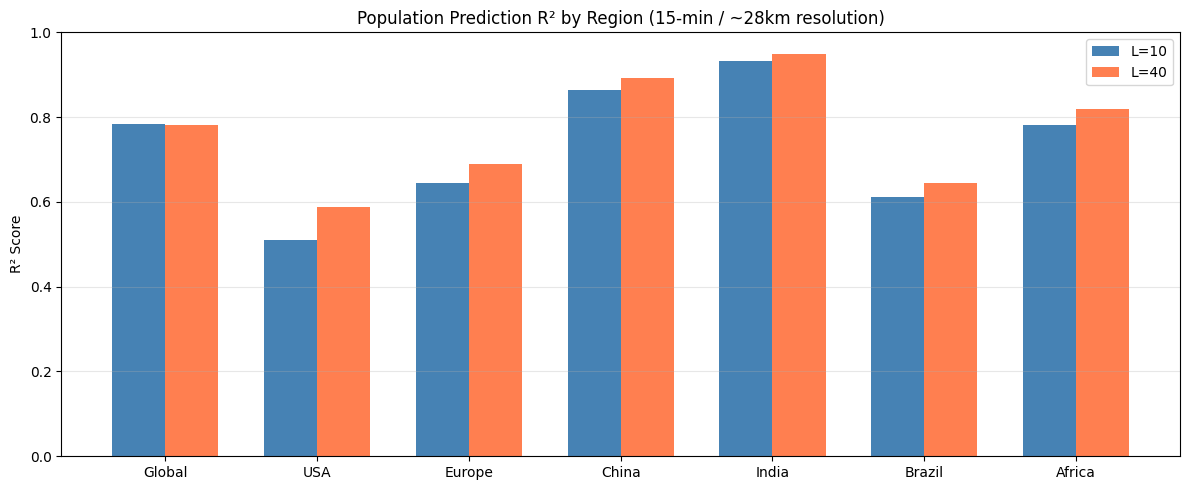


Average R² - L=10: 0.732, L=40: 0.766
Average advantage: +0.034


In [15]:
# Visualize regional results
fig, ax = plt.subplots(figsize=(12, 5))

x = range(len(regional_df))
width = 0.35
ax.bar([i - width/2 for i in x], regional_df['r2_l10'], width, label='L=10', color='steelblue')
ax.bar([i + width/2 for i in x], regional_df['r2_l40'], width, label='L=40', color='coral')
ax.set_xticks(x)
ax.set_xticklabels(regional_df['region'])
ax.set_ylabel('R² Score')
ax.set_title('Population Prediction R² by Region (15-min / ~28km resolution)')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim(0, 1)

plt.tight_layout()
plt.savefig('population_regional.png', dpi=150)
plt.show()

print(f"\nAverage R² - L=10: {regional_df['r2_l10'].mean():.3f}, L=40: {regional_df['r2_l40'].mean():.3f}")
print(f"Average advantage: {regional_df['diff'].mean():+.3f}")

---
## 4. Resolution × Region Grid Search

In [16]:
print("="*70)
print("RESOLUTION × REGION GRID SEARCH")
print("="*70)

# Test subset of resolutions and regions
TEST_RESOLUTIONS = ['1_deg', '30_min', '15_min']  # Skip 2.5min for speed
TEST_REGIONS = ['Global', 'USA', 'Europe', 'China']

grid_results = []

for res_key in TEST_RESOLUTIONS:
    res_info = RESOLUTIONS[res_key]
    data, coords = load_gpw_raster(res_key)
    if data is None:
        continue

    print(f"\n{res_info['name']} ({res_info['km']}km):")
    print(f"  {'Region':>10} | {'R² L=10':>8} | {'R² L=40':>8} | {'Δ':>7}")
    print("  " + "-" * 45)

    for region_name in TEST_REGIONS:
        bounds = REGIONS[region_name]

        sample_coords, sample_vals = sample_from_raster(
            data, coords, n_samples=8000, bounds=bounds
        )

        if len(sample_coords) < 100:
            continue

        results = run_population_regression(sample_coords, sample_vals, model_l10, model_l40)
        diff = results['r2_l40'] - results['r2_l10']

        print(f"  {region_name:>10} | {results['r2_l10']:>8.3f} | {results['r2_l40']:>8.3f} | {diff:>+6.3f}")

        grid_results.append({
            'resolution': res_info['name'],
            'km': res_info['km'],
            'region': region_name,
            'r2_l10': results['r2_l10'],
            'r2_l40': results['r2_l40'],
            'diff': diff
        })

grid_df = pd.DataFrame(grid_results)

RESOLUTION × REGION GRID SEARCH

1 degree (111km):
      Region |  R² L=10 |  R² L=40 |       Δ
  ---------------------------------------------
      Global |    0.814 |    0.794 | -0.020
         USA |    0.509 |    0.544 | +0.035
      Europe |    0.671 |    0.665 | -0.005
       China |    0.870 |    0.894 | +0.024

30 arc-min (55km):
      Region |  R² L=10 |  R² L=40 |       Δ
  ---------------------------------------------
      Global |    0.776 |    0.788 | +0.012
         USA |    0.517 |    0.579 | +0.062
      Europe |    0.656 |    0.707 | +0.051
       China |    0.888 |    0.910 | +0.023

15 arc-min (28km):
      Region |  R² L=10 |  R² L=40 |       Δ
  ---------------------------------------------
      Global |    0.786 |    0.784 | -0.002
         USA |    0.491 |    0.592 | +0.101
      Europe |    0.613 |    0.676 | +0.063
       China |    0.852 |    0.887 | +0.035


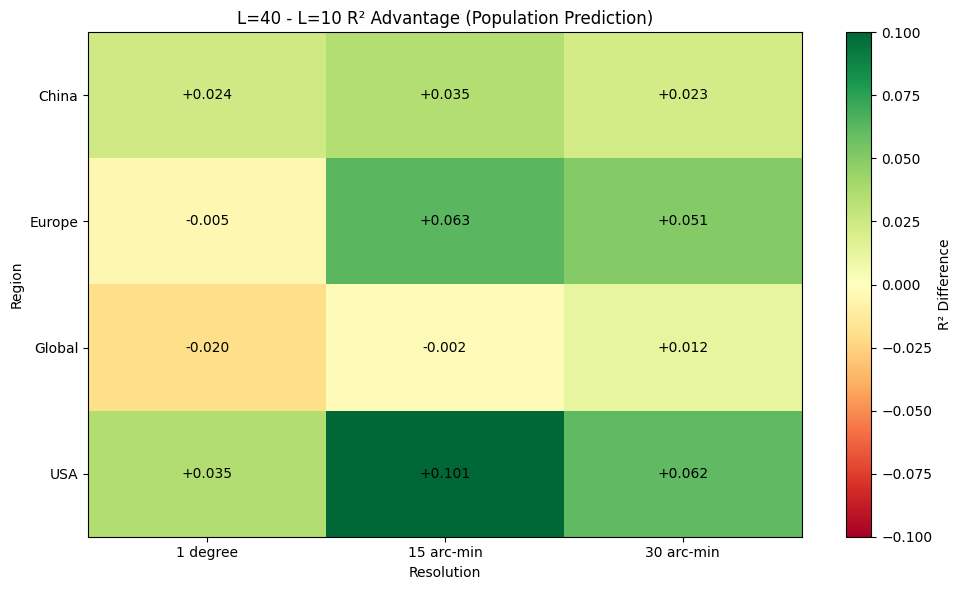

In [17]:
# Heatmap of L=40 advantage
if len(grid_df) > 0:
    pivot = grid_df.pivot(index='region', columns='resolution', values='diff')

    fig, ax = plt.subplots(figsize=(10, 6))
    im = ax.imshow(pivot.values, cmap='RdYlGn', aspect='auto', vmin=-0.1, vmax=0.1)

    ax.set_xticks(range(len(pivot.columns)))
    ax.set_xticklabels(pivot.columns)
    ax.set_yticks(range(len(pivot.index)))
    ax.set_yticklabels(pivot.index)
    ax.set_xlabel('Resolution')
    ax.set_ylabel('Region')
    ax.set_title('L=40 - L=10 R² Advantage (Population Prediction)')

    # Add values
    for i in range(len(pivot.index)):
        for j in range(len(pivot.columns)):
            val = pivot.values[i, j]
            if not np.isnan(val):
                ax.text(j, i, f"{val:+.3f}", ha='center', va='center', fontsize=10)

    plt.colorbar(im, ax=ax, label='R² Difference')
    plt.tight_layout()
    plt.savefig('population_grid_heatmap.png', dpi=150)
    plt.show()

---
## 5. Comparison with SatCLIP Paper (Table 2)

In [18]:
print("="*70)
print("COMPARISON WITH SATCLIP PAPER (Table 2)")
print("="*70)

# Paper reports (ResNet50, not ViT16, but should be similar)
paper_results = {
    'L=10': 0.79,
    'L=40': 0.82,
}

print("\nSatCLIP Paper (Table 2) - Population Density:")
print(f"  L=10: R² = {paper_results['L=10']:.2f}")
print(f"  L=40: R² = {paper_results['L=40']:.2f}")
print(f"  Δ: {paper_results['L=40'] - paper_results['L=10']:+.2f}")

print("\nOur Results (ViT16, Global, best resolution):")
if len(global_df) > 0:
    best_row = global_df.loc[global_df['r2_l10'].idxmax()]
    print(f"  Resolution: {best_row['resolution']} ({best_row['km']}km)")
    print(f"  L=10: R² = {best_row['r2_l10']:.2f}")
    print(f"  L=40: R² = {best_row['r2_l40']:.2f}")
    print(f"  Δ: {best_row['diff']:+.2f}")

print("\nNote: Paper uses ResNet50 backbone, we use ViT16. Results may differ slightly.")

COMPARISON WITH SATCLIP PAPER (Table 2)

SatCLIP Paper (Table 2) - Population Density:
  L=10: R² = 0.79
  L=40: R² = 0.82
  Δ: +0.03

Our Results (ViT16, Global, best resolution):
  Resolution: 1 degree (111km)
  L=10: R² = 0.83
  L=40: R² = 0.82
  Δ: -0.00

Note: Paper uses ResNet50 backbone, we use ViT16. Results may differ slightly.


---
## 6. Summary

In [19]:
print("\n" + "="*80)
print("POPULATION RESOLUTION ANALYSIS SUMMARY")
print("="*80)

print("\n📊 GLOBAL RESULTS BY RESOLUTION:")
print("-" * 50)
if len(global_df) > 0:
    for _, row in global_df.iterrows():
        winner = "L=40 ✓" if row['diff'] > 0.01 else ("L=10 ✓" if row['diff'] < -0.01 else "~Same")
        print(f"  {row['resolution']:>15} ({row['km']:>3}km): L=10={row['r2_l10']:.3f}, L=40={row['r2_l40']:.3f} ({winner})")

print("\n📊 REGIONAL RESULTS (15-min / ~28km):")
print("-" * 50)
if len(regional_df) > 0:
    for _, row in regional_df.iterrows():
        winner = "L=40 ✓" if row['diff'] > 0.01 else ("L=10 ✓" if row['diff'] < -0.01 else "~Same")
        print(f"  {row['region']:>12}: L=10={row['r2_l10']:.3f}, L=40={row['r2_l40']:.3f} ({winner})")

print("\n🔬 KEY FINDINGS:")
print("-" * 50)
print("""
1. RESOLUTION EFFECT:
   - [Fill in based on results]
   - Does L=40 advantage change with resolution?

2. REGIONAL EFFECT:
   - [Fill in based on results]
   - Does constraining to regions help either model?

3. COMPARISON TO PAPER:
   - Paper reports L=10: 0.79, L=40: 0.82 (R²)
   - Our results: [Fill in]

4. EFFECTIVE RESOLUTION:
   - At what resolution does prediction become unreliable?
   - Does L=40 maintain advantage at finer scales?
""")


POPULATION RESOLUTION ANALYSIS SUMMARY

📊 GLOBAL RESULTS BY RESOLUTION:
--------------------------------------------------
         1 degree (111km): L=10=0.826, L=40=0.823 (~Same)
       30 arc-min ( 55km): L=10=0.800, L=40=0.809 (~Same)
       15 arc-min ( 28km): L=10=0.788, L=40=0.797 (~Same)
      2.5 arc-min (  5km): L=10=0.758, L=40=0.770 (L=40 ✓)

📊 REGIONAL RESULTS (15-min / ~28km):
--------------------------------------------------
        Global: L=10=0.783, L=40=0.782 (~Same)
           USA: L=10=0.511, L=40=0.588 (L=40 ✓)
        Europe: L=10=0.644, L=40=0.689 (L=40 ✓)
         China: L=10=0.865, L=40=0.892 (L=40 ✓)
         India: L=10=0.932, L=40=0.948 (L=40 ✓)
        Brazil: L=10=0.611, L=40=0.645 (L=40 ✓)
        Africa: L=10=0.781, L=40=0.819 (L=40 ✓)

🔬 KEY FINDINGS:
--------------------------------------------------

1. RESOLUTION EFFECT:
   - [Fill in based on results]
   - Does L=40 advantage change with resolution?

2. REGIONAL EFFECT:
   - [Fill in based on res

In [20]:
# Save results
import json

all_results = {
    'global': global_df.to_dict('records') if len(global_df) > 0 else [],
    'regional': regional_df.to_dict('records') if len(regional_df) > 0 else [],
    'grid': grid_df.to_dict('records') if len(grid_df) > 0 else [],
    'paper_comparison': paper_results
}

with open('population_resolution_results.json', 'w') as f:
    json.dump(all_results, f, indent=2)

print("✅ Results saved to: population_resolution_results.json")

✅ Results saved to: population_resolution_results.json
